# Homework 4 : Harshita Mahesh Hiremath

In [1]:
import numpy as np
import gzip
import struct
import matplotlib.pyplot as plt

In [2]:
#Step 1:(a)
def read_idx(filename):
    with gzip.open(filename,'rb') as f:
        zero,data_type, dims = struct.unpack('>HBB',f.read(4))
        shape = tuple(struct.unpack('>I',f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(),dtype=np.uint8).reshape(shape)

In [3]:
images = read_idx('train-images-idx3-ubyte.gz')
label = read_idx('train-labels-idx1-ubyte.gz')
test_images = read_idx('t10k-images-idx3-ubyte.gz')
test_label = read_idx('t10k-labels-idx1-ubyte.gz')

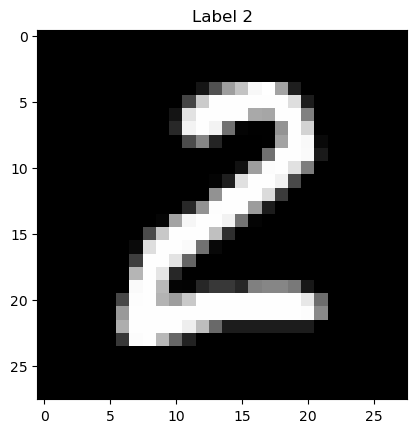

In [4]:
#Step 1:(b)
random_idx = np.random.choice(len(images))
plt.imshow(images[random_idx],cmap='gray')
plt.title(f'Label {label[random_idx]}')
plt.show()

In [5]:
#Step 2

#np.max(images)
normalized_images = images / 255.0
#np.min(normalized_images)
#np.max(normalized_images)

one_hot_labels = np.eye(10)[label]
#label
#one_hot_labels[2]
#normalized_images

In [6]:
#Step 3

# Initialize weights and biases
def initialize_parameters(input_size, hidden_layer1_size, hidden_layer2_size, output_size):
    
    #W1 = np.random.randn(hidden_layer1_size, input_size) * 0.01
    W1 = np.random.randn(hidden_layer1_size, input_size) * np.sqrt(2/input_size)
    b1 = np.zeros((hidden_layer1_size, 1))

    W2 = np.random.randn(hidden_layer2_size, hidden_layer1_size)  * np.sqrt(2/hidden_layer1_size)
    b2 = np.zeros((hidden_layer2_size, 1))

    W3 = np.random.randn(output_size, hidden_layer2_size)  * np.sqrt(2/hidden_layer2_size)
    b3 = np.zeros((output_size, 1))

    return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}

# Set the random seed
np.random.seed(695)

# Input size
input_size = 784

# Hidden layer sizes
hidden_layer1_size = 128
hidden_layer2_size = 64

# Output layer size
output_size = 10

# Initialize parameters
parameters = initialize_parameters(input_size, hidden_layer1_size, hidden_layer2_size, output_size)
#print(parameters)

In [7]:
#Step 4
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True)) # Subtracting max(z) for numerical stability
    return exp_z / (np.sum(exp_z, axis=0, keepdims=True) + 1e-12)

def batch_normalize(x):
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    return (x - mean) / (std + 1e-8)

def feed_forward(x, parameters):
    # Extract parameters
    W1, b1, W2, b2, W3, b3 = parameters.values()

    # First hidden layer
    z1 = np.dot(x, W1.T) + b1.T  # Transpose W1
    a1 = sigmoid(z1)

    # Second hidden layer
    z2 = np.dot(a1, W2.T) + b2.T  # Transpose W2
    a2 = sigmoid(z2)

    # Output layer
    z3 = np.dot(a2, W3.T) + b3.T  # Transpose W3
    output = softmax(z3)

    return output

In [8]:
def categorical_cross_entropy_loss(y_true, y_pred):
    n_samples = y_true.shape[0]
    y_pred_clipped = np.clip(y_pred,1e-12,1 - 1e-12)
    return -np.sum(y_true*np.log(y_pred_clipped))/n_samples

#categorical_cross_entropy_loss(one_hot_labels, y_pred)

In [9]:
def sigmoid_derivative(x):
    
    return sigmoid(x) * (1 - sigmoid(x))

def backward_pass(x, y_true, parameters, output):
 
    W1, b1, W2, b2, W3, b3 = parameters.values()

    # Forward pass
    z1 = np.dot(x, W1.T) + b1.T
    a1 = sigmoid(z1)

    z2 = np.dot(a1, W2.T) + b2.T
    a2 = sigmoid(z2)

    z3 = np.dot(a2, W3.T) + b3.T
    output = softmax(z3)

    # Calculate gradients for the output layer
    dL_dz3 = output - y_true
    dL_dW3 = np.dot(dL_dz3.T, a2)  # Transpose a2
    dL_db3 = np.sum(dL_dz3, axis=0, keepdims=True)

    # Calculate gradients for the second hidden layer
    dL_da2 = np.dot(dL_dz3, W3)
    dL_dz2 = dL_da2 * sigmoid_derivative(z2)
    dL_dW2 = np.dot(dL_dz2.T, a1)  # Transpose a1
    dL_db2 = np.sum(dL_dz2, axis=0, keepdims=True)

    # Calculate gradients for the first hidden layer
    dL_da1 = np.dot(dL_dz2, W2)
    dL_dz1 = dL_da1 * sigmoid_derivative(z1)
    dL_dW1 = np.dot(dL_dz1.T, x)  # Transpose x
    dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)

    gradients = {'dL_dW1': dL_dW1, 'dL_db1': dL_db1, 'dL_dW2': dL_dW2, 'dL_db2': dL_db2, 'dL_dW3': dL_dW3, 'dL_db3': dL_db3}
    return gradients

In [10]:
# Hyperparameters
initial_learning_rate = 0.0001
decay_rate = 0.9
batch_size = 128
epochs = 100
X = normalized_images
X = X.reshape(X.shape[0], -1)
y_true = one_hot_labels

# Training loop
for epoch in range(epochs):
    # Shuffle the training data for each epoch (assuming X and y_true are shuffled accordingly)
    learning_rate = initial_learning_rate * (decay_rate ** epoch)
    if epoch % 10 == 0:
        learning_rate /= 2
    permutation = np.random.permutation(X.shape[0])
    X_shuffled = X[permutation, :]
    y_true_shuffled = y_true[permutation, :]

    # Mini-batch loop
    for i in range(0, X.shape[0], batch_size):
        # Get the mini-batch
        mini_batch_X = X_shuffled[i:i+batch_size, :]
        mini_batch_y_true = y_true_shuffled[i:i+batch_size, :]

        # Forward pass
        output = feed_forward(mini_batch_X, parameters)

        # Backward pass
        gradients = backward_pass(mini_batch_X, mini_batch_y_true, parameters, output)

        # Update parameters using gradient descent
        for param in parameters:
            parameters[param] -= learning_rate * gradients[f'dL_d{param}'].reshape(parameters[param].shape)


    # Calculate and print the training loss for the current epoch
    output = feed_forward(X, parameters)
    loss = categorical_cross_entropy_loss(y_true, output)
    
    # Print additional information (e.g., training accuracy, validation loss)
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss}')

Epoch 1/100, Loss: 10.985291242691245
Epoch 2/100, Loss: 11.00258195445173
Epoch 3/100, Loss: 11.00271561143123
Epoch 4/100, Loss: 11.002538390025393
Epoch 5/100, Loss: 11.002440457685594
Epoch 6/100, Loss: 11.00362663327112
Epoch 7/100, Loss: 11.022885475772846
Epoch 8/100, Loss: 11.132302358893222
Epoch 9/100, Loss: 11.316127288654616
Epoch 10/100, Loss: 11.49879333158795
Epoch 11/100, Loss: 11.58213457768141
Epoch 12/100, Loss: 11.733324874542086
Epoch 13/100, Loss: 11.871434894367589
Epoch 14/100, Loss: 12.000996009208764
Epoch 15/100, Loss: 12.126885506352506
Epoch 16/100, Loss: 12.266656782511156
Epoch 17/100, Loss: 12.39215726213757
Epoch 18/100, Loss: 12.518057402399279
Epoch 19/100, Loss: 12.659343613639958
Epoch 20/100, Loss: 12.715901777677887
Epoch 21/100, Loss: 12.74407768990741
Epoch 22/100, Loss: 12.800671312397153
Epoch 23/100, Loss: 12.858620628200738
Epoch 24/100, Loss: 12.916658821970662
Epoch 25/100, Loss: 12.973640118464983
Epoch 26/100, Loss: 13.028679011075331
Ep

In [11]:
# Assuming 'test_images' is your test dataset and 'test_label' is the corresponding labels
# 'parameters' is a dictionary containing trained weights and biases

# Reshape the test data
X_test = test_images.reshape(test_images.shape[0], -1)

# Forward pass to get predictions
y_pred = feed_forward(X_test, parameters)

# Convert predicted probabilities to one-hot encoded labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Compare predicted labels with true labels
accuracy = np.mean(y_pred_labels == test_label)
print(f"Accuracy on the test dataset: {accuracy * 100:.2f}%")

Accuracy on the test dataset: 11.35%


/var/folders/sg/3tj_k0kn1315z20ckp9dznph0000gn/T/ipykernel_7293/3688818161.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


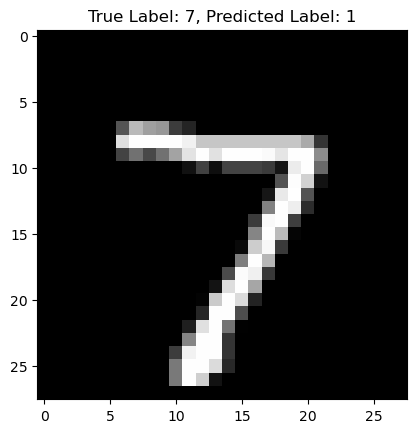

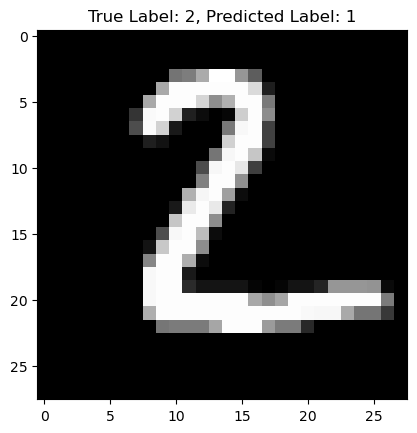

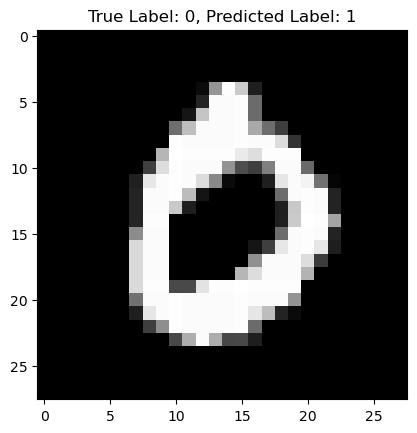

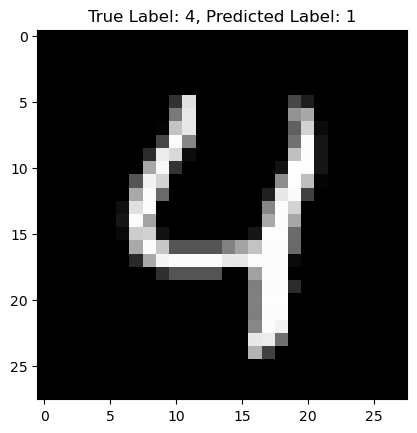

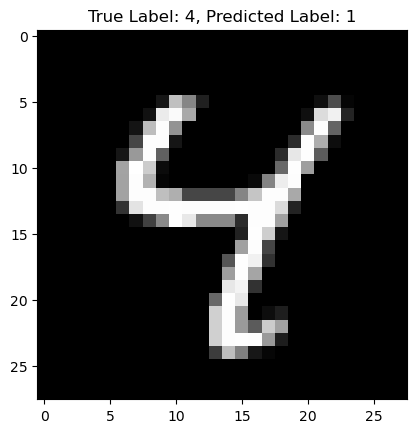

In [12]:
# Find misclassified indices
misclassified_indices = np.where(y_pred_labels != test_label)[0]

# Plot some of the misclassified images
num_misclassified_to_plot = 5  # Choose the number of misclassified images to plot

for i in range(min(num_misclassified_to_plot, len(misclassified_indices))):
    index = misclassified_indices[i]
    plt.imshow(test_images[index], cmap='gray')
    plt.title(f'True Label: {test_label[index]}, Predicted Label: {y_pred_labels[index]}')
    plt.show()